## **Analyse des données avant merge des bases**

In [2]:
import pandas as pd
import numpy as np 
from helpers2 import S3Connection
import helpers2 
import matplotlib.pyplot as plt

In [3]:
s3 = S3Connection(bucket_name="clichere/diffusion")

Connection successful


In [4]:
path1 = "DPE/DPE_après_2021.parquet"
DPE = s3.get_tables_from_s3(path1)

In [5]:
path2 = "Valeursfoncières/vf.parquet"
vf = s3.get_tables_from_s3(path2)

### **premières statistiques descriptives**

In [6]:
DPE.columns

Index(['Date_établissement_DPE', 'Modèle_DPE', 'Version_DPE', 'Etiquette_DPE',
       'Etiquette_GES', 'Année_construction', 'Type_bâtiment',
       'Période_construction', 'Surface_habitable_logement',
       'Code_INSEE_(BAN)', 'Adresse_(BAN)', 'Score_BAN',
       'Coordonnée_cartographique_X_(BAN)',
       'Coordonnée_cartographique_Y_(BAN)', 'N°_étage_appartement',
       'N°_région_(BAN)'],
      dtype='object')

In [7]:
print("Nombre de lignes par colonnes:", len(DPE))
total_nan = DPE.isna().sum().sum()
print(f"Nombre total de NaN : {total_nan}")
nan_par_colonne = DPE.isna().sum()
top_10_nan_colonnes = nan_par_colonne.sort_values(ascending=False).head(10)
print("Les 10 colonnes avec le plus de NaN :")
print(top_10_nan_colonnes)

Nombre de lignes par colonnes: 4074868
Nombre total de NaN : 2570649
Les 10 colonnes avec le plus de NaN :
Année_construction                   1257443
N°_étage_appartement                 1163134
Surface_habitable_logement             44799
Adresse_(BAN)                          22236
N°_région_(BAN)                        18877
Coordonnée_cartographique_Y_(BAN)      16040
Code_INSEE_(BAN)                       16040
Score_BAN                              16040
Coordonnée_cartographique_X_(BAN)      16040
Période_construction                       0
dtype: int64


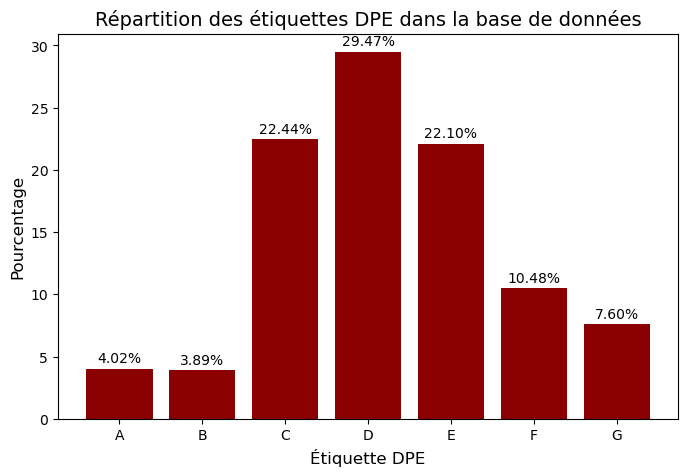

In [8]:
resultat_dpe = DPE["Etiquette_DPE"].value_counts(normalize=True) * 100

resultat_dpe = resultat_dpe.reindex(sorted(resultat_dpe.index))

# Histogramme des étiquettes DPE dans la base de données 
fig, ax = plt.subplots(figsize=(8, 5))

# Histogramme
ax.bar(resultat_dpe.index, resultat_dpe.values, color='darkred')

# Titres et labels
ax.set_title("Répartition des étiquettes DPE dans la base de données", fontsize=14)
ax.set_xlabel("Étiquette DPE", fontsize=12)
ax.set_ylabel("Pourcentage", fontsize=12)

# Ajout des valeurs sur les barres
for i, v in enumerate(resultat_dpe):
    ax.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontsize=10)

# Affichage du graphique
plt.show()

In [10]:
DPE["N°_région_(BAN)"] = pd.to_numeric(DPE["N°_région_(BAN)"], errors="coerce")
DPE_filtre101 = DPE[DPE["N°_région_(BAN)"] <= 101]
DPE_filtre101["N°_région_(BAN)"] = DPE_filtre101["N°_région_(BAN)"].astype(int).astype(str).str.zfill(2)
resultat = DPE_filtre101.groupby("N°_région_(BAN)")["Etiquette_DPE"].value_counts(normalize=True).unstack() * 100
pd.options.display.float_format = "{:.2f}%".format
print(resultat)

# Trouver le département avec le plus de logements en A et G
logements_A = DPE_filtre101[DPE_filtre101["Etiquette_DPE"] == "A"]
logements_G = DPE_filtre101[DPE_filtre101["Etiquette_DPE"] == "G"]
logements_A_count = logements_A["N°_région_(BAN)"].value_counts()
logements_G_count = logements_G["N°_région_(BAN)"].value_counts()
departement_max_A = logements_A_count.idxmax()
departement_max_G = logements_G_count.idxmax()
print(f"Le département avec le plus de logements en A : {departement_max_A} ({logements_A_count.max()} logements)")
print(f"Le département avec le plus de logements en G : {departement_max_G} ({logements_G_count.max()} logements)")

/tmp/ipykernel_12461/2389958458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DPE_filtre101["N°_région_(BAN)"] = DPE_filtre101["N°_région_(BAN)"].astype(int).astype(str).str.zfill(2)


Etiquette_DPE        A      B      C      D      E      F      G
N°_région_(BAN)                                                 
00                 NaN    NaN    NaN 83.33% 16.67%    NaN    NaN
01              12.15%  7.99% 36.46% 27.43% 10.76%  3.47%  1.74%
02               1.17%  6.95% 50.57% 28.31%  9.55%  2.50%  0.95%
03               3.03%    NaN 30.30% 48.48%  9.09%  6.06%  3.03%
04              17.05%  3.88% 25.19% 23.26% 19.77%  6.98%  3.88%
06               5.26% 10.53%    NaN 52.63% 26.32%  5.26%    NaN
11               1.62%  3.14% 19.51% 26.13% 24.62% 13.14% 11.84%
24               3.15%  3.30% 18.59% 31.48% 24.51% 11.19%  7.78%
27               2.74%  2.74% 18.94% 29.24% 24.34% 12.37%  9.62%
28               3.27%  2.98% 16.57% 29.04% 25.69% 12.79%  9.65%
32               1.64%  2.32% 18.88% 32.76% 25.74% 11.28%  7.37%
44               2.12%  2.67% 23.82% 31.52% 22.72% 10.63%  6.52%
52               6.46%  4.51% 24.03% 30.03% 20.00%  9.04%  5.93%
53               6.50%  4

Pas logique, il n'y a pas 94 régions en France. Est-ce que ce sont les départements? 
C'est bizarre d'avoir une liste comme ça

/tmp/ipykernel_12461/3896070570.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(j, resultat_reg[j] + 0.20, f"{resultat_reg[j]:.2f}%", ha='center', va='bottom')
/tmp/ipykernel_12461/3896070570.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(j, resultat_reg[j] + 0.20, f"{resultat_reg[j]:.2f}%", ha='center', va='bottom')
/tmp/ipykernel_12461/3896070570.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt

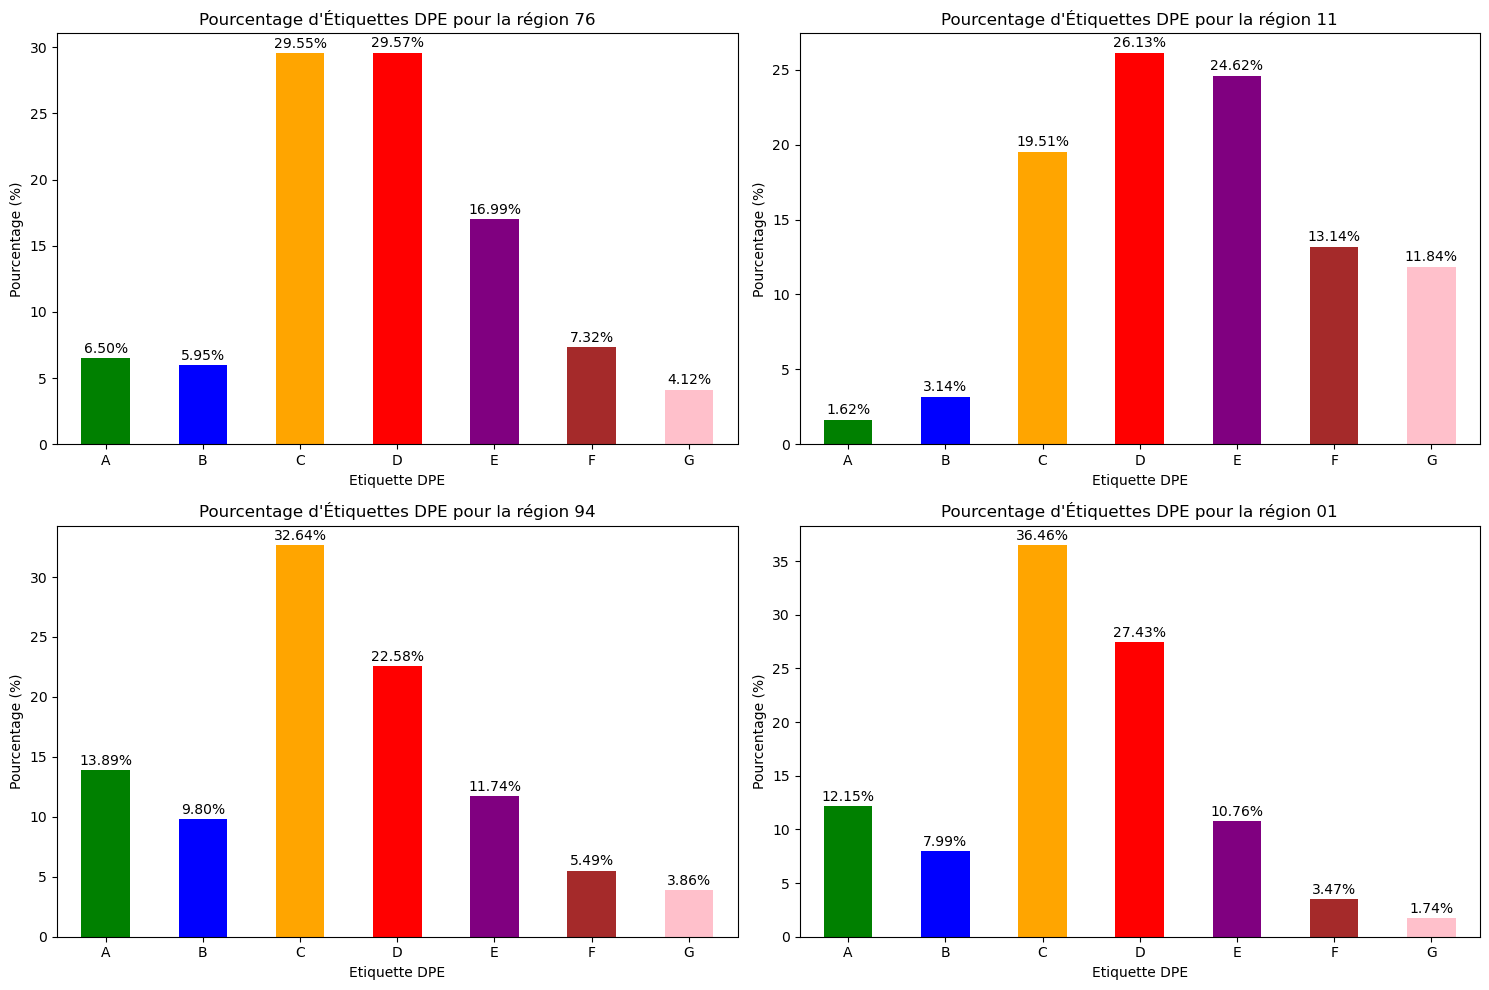

In [ ]:
region = ["76", "11", "94", "01"]

# Histogramme pour chaque région
plt.figure(figsize=(15, 10))

for i, reg in enumerate(region, 1):
    plt.subplot(2, 2, i)  
    resultat_reg = resultat.loc[reg]  
    
    # Histogramme pour chaque département
    resultat_reg.plot(kind='bar', color=['green', 'blue', 'orange', 'red', 'purple', 'brown', 'pink'])
    plt.title(f"Pourcentage d'Étiquettes DPE pour la région {reg}", fontsize=12)
    plt.xlabel("Etiquette DPE", fontsize=10)
    plt.ylabel("Pourcentage (%)", fontsize=10)
    for j in range(len(resultat_reg)):
        plt.text(j, resultat_reg[j] + 0.20, f"{resultat_reg[j]:.2f}%", ha='center', va='bottom')
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Pas logique, je ne comprend pas à quoi correspondent les numéros de région. 